In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
from scipy import ndimage
import coop_setup_funcs as csf
import warnings
from astropy.visualization import quantity_support
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
import healpy as hp

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import stats as st

In [5]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
actpath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
desmask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"

0.19985555905328484 redshift 0.3565167560560754 redshift
0.3565167560560754 redshift 0.5289988643902372 redshift
0.5289988643902372 redshift 0.7215854982816572 redshift
0.7215854982816572 redshift 0.9396687416637612 redshift


In [6]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24


retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_mask_redmapper_lambdagt20_combined_893_1393Mpc_nugt2_egtpt3_20pt0_orientXYUP_100pct_maglim_843_1443Mpc_cc_24reg_m0to5_profiles.pkl


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


548


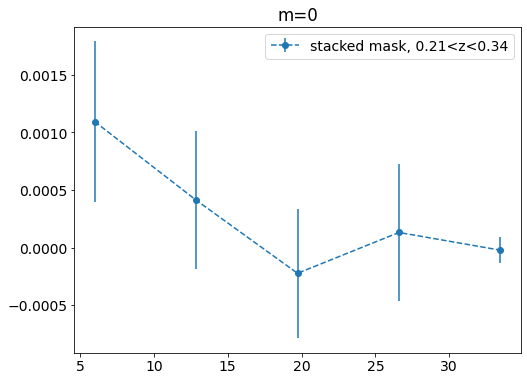

24 24


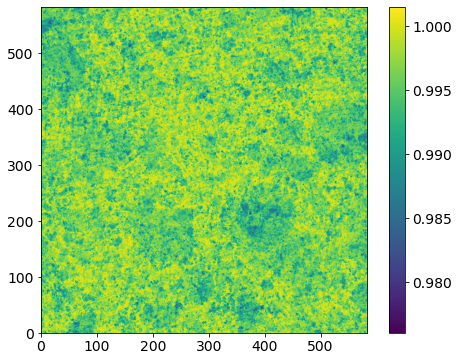

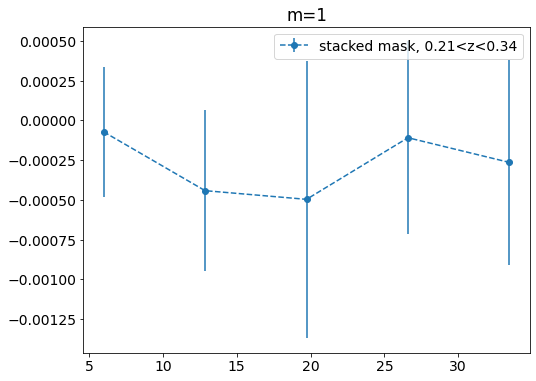

24 24


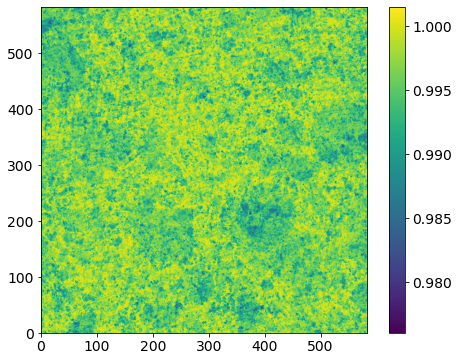

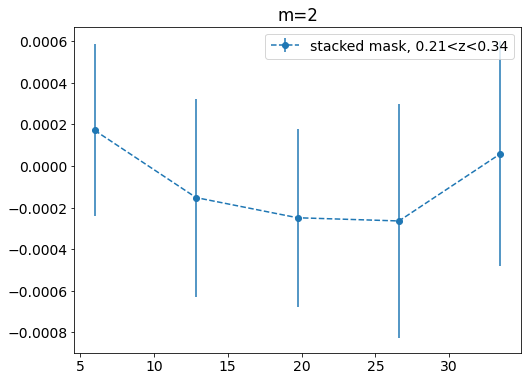

24 24


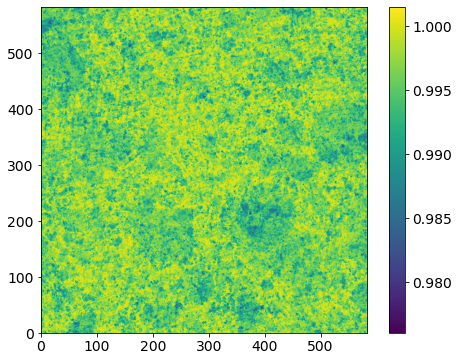

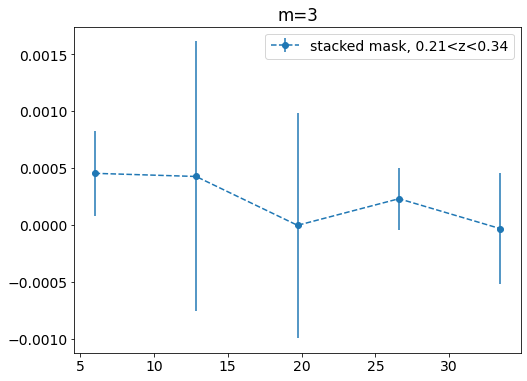

24 24


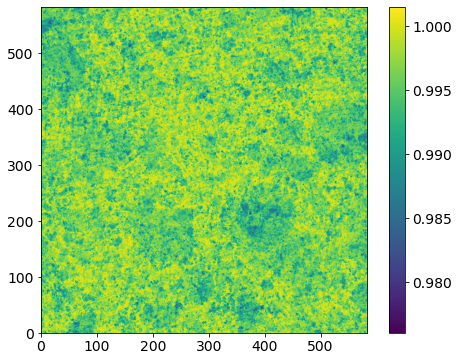

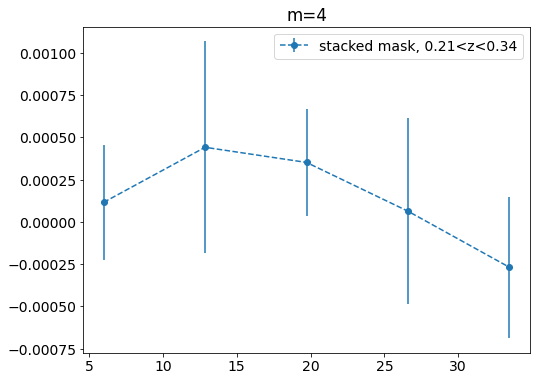

24 24


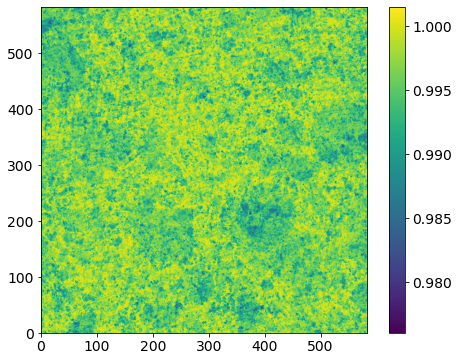

retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_mask_redmapper_lambdagt20_combined_1493_1993Mpc_nugt2_egtpt3_20pt0_orientXYUP_100pct_maglim_1443_2043Mpc_cc_24reg_m0to5_profiles.pkl
804


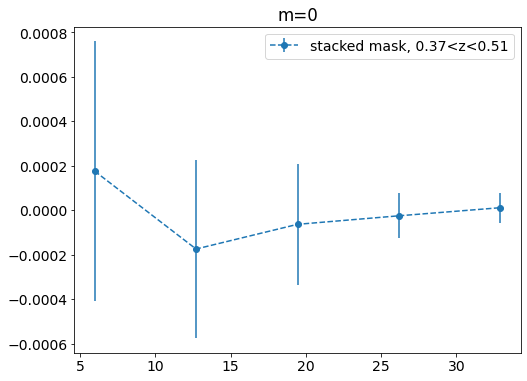

24 24


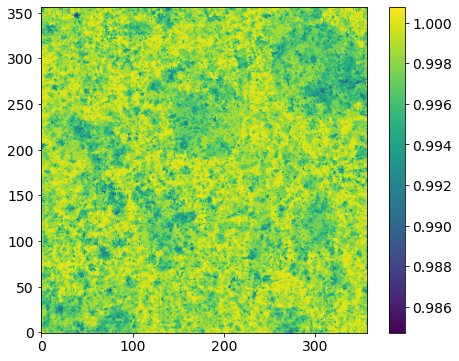

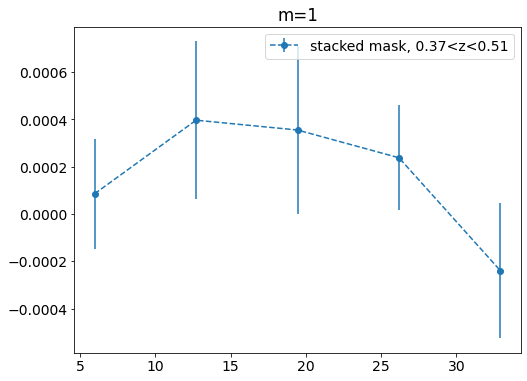

24 24


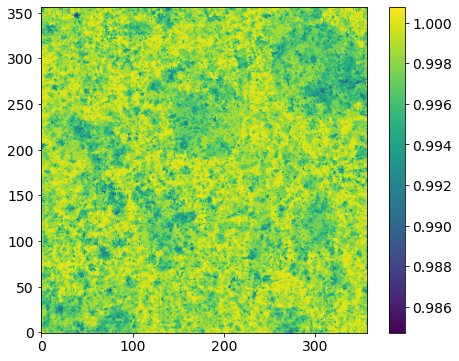

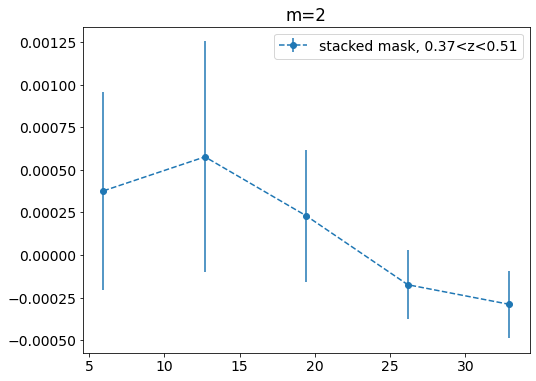

24 24


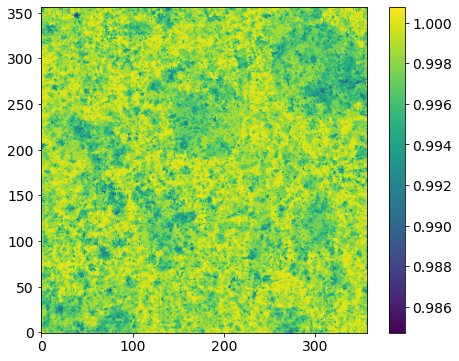

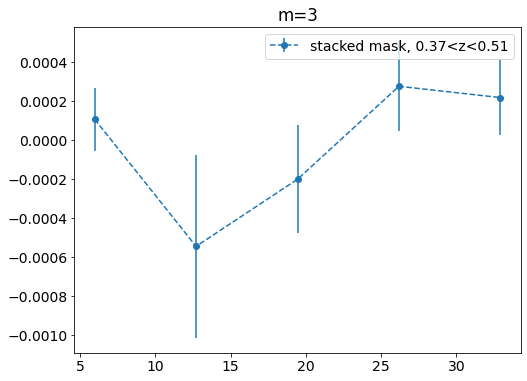

24 24


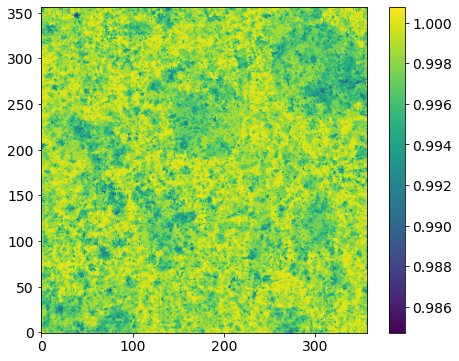

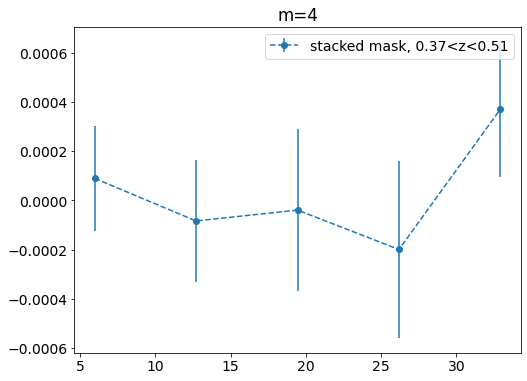

24 24


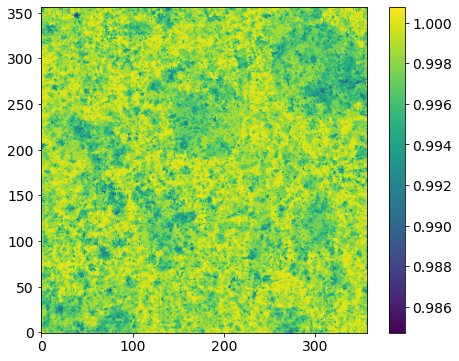

retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_mask_redmapper_lambdagt20_combined_2093_2593Mpc_nugt2_egtpt3_20pt0_orientXYUP_100pct_maglim_2043_2643Mpc_cc_24reg_m0to5_profiles.pkl
1361


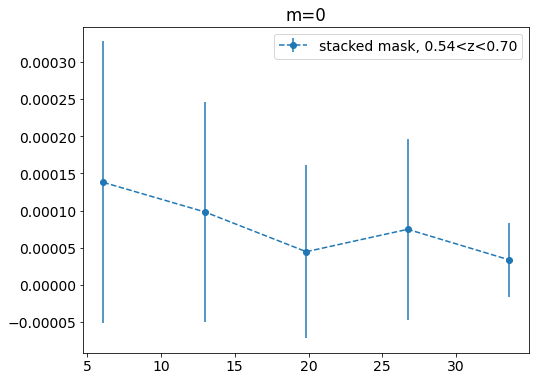

24 24


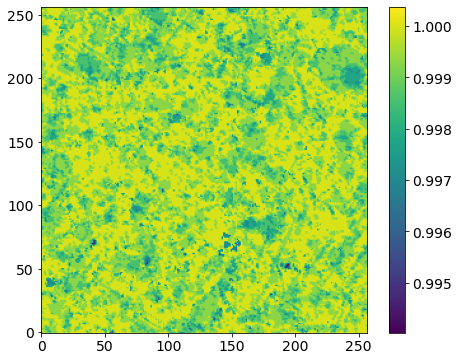

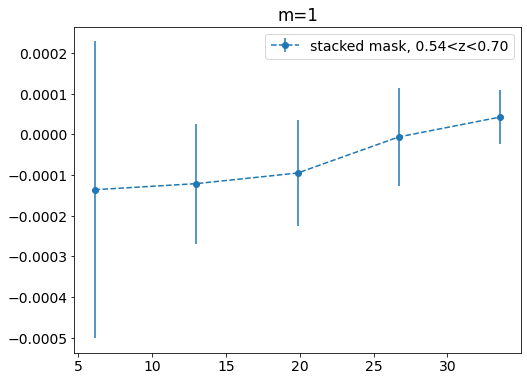

24 24


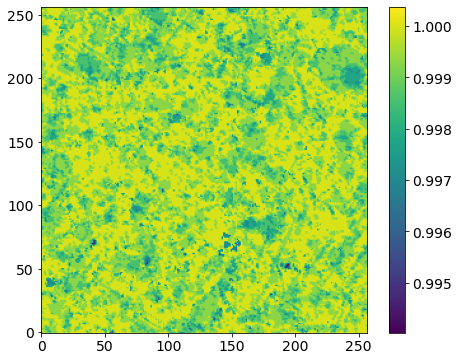

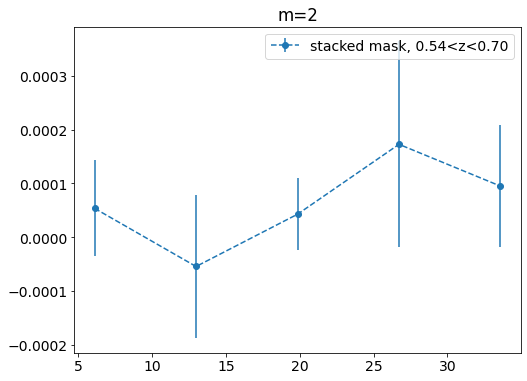

24 24


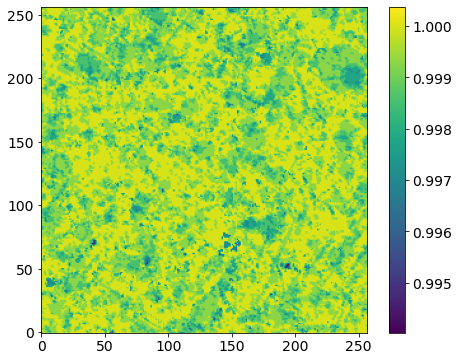

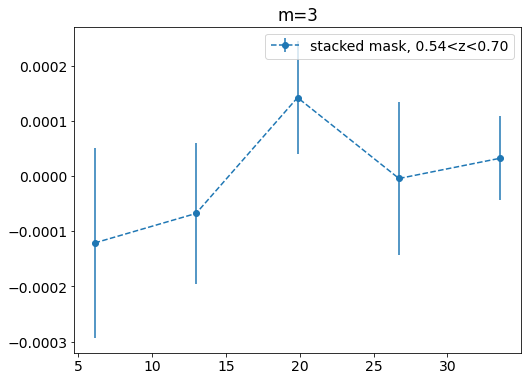

24 24


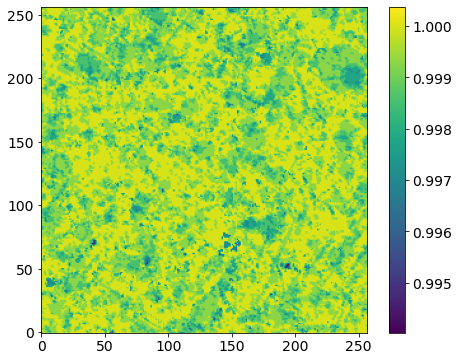

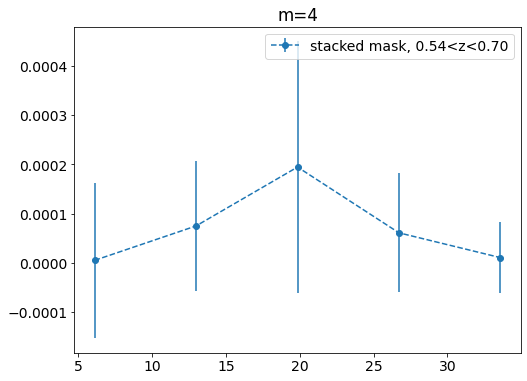

24 24


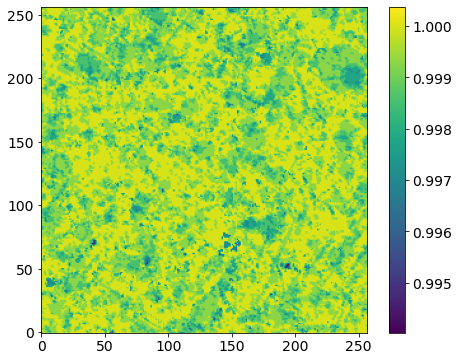

retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_mask_redmapper_lambdagt20_combined_2693_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_100pct_maglim_2643_3243Mpc_cc_24reg_m0to5_profiles.pkl
2163
not pos def


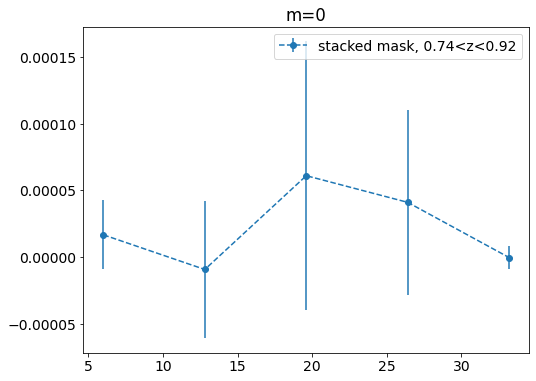

24 24


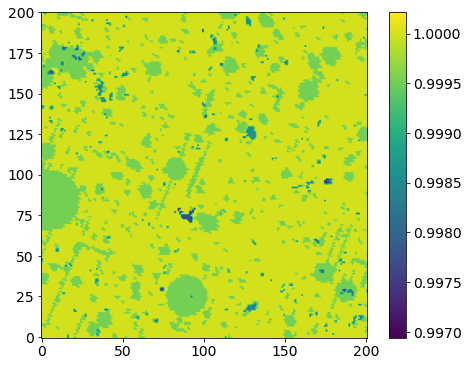

not pos def


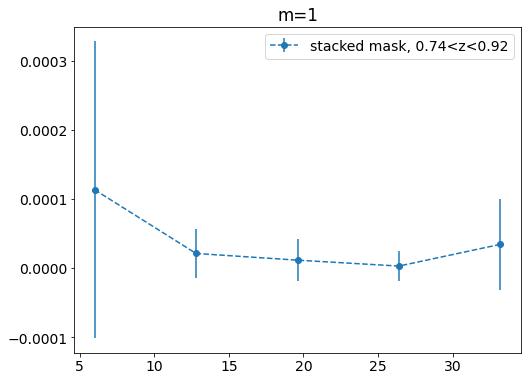

24 24


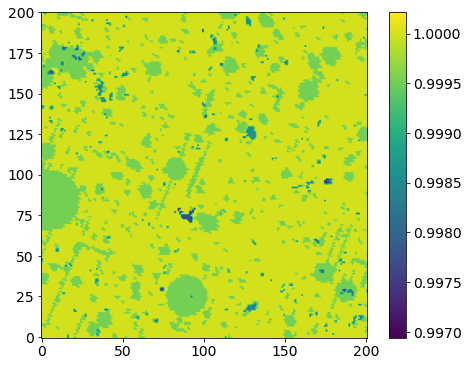

not pos def


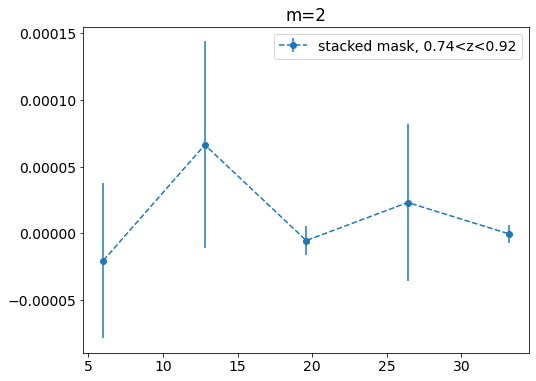

24 24


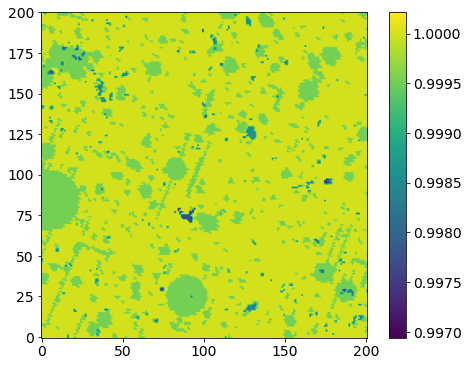

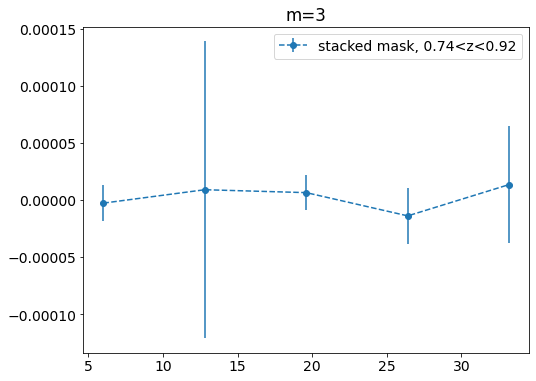

24 24


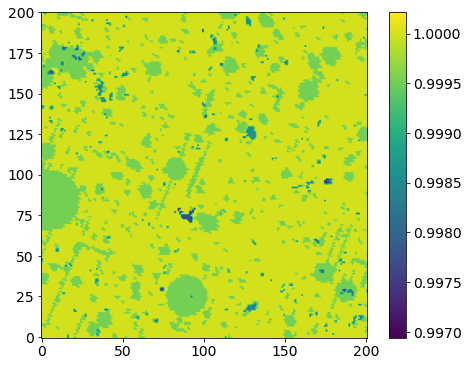

not pos def


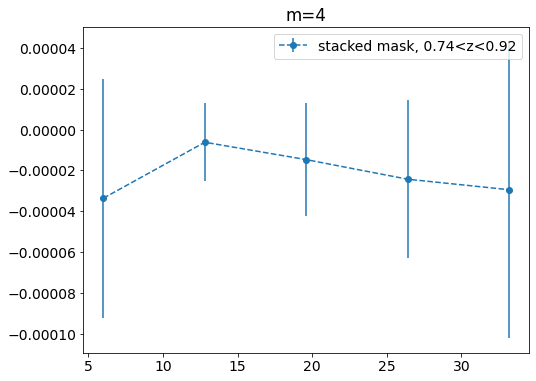

24 24


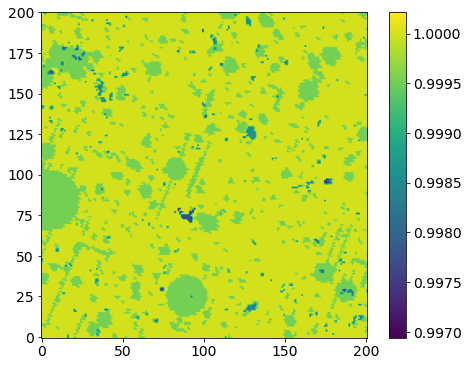

<Figure size 576x432 with 0 Axes>

In [7]:
profs_dbin = []
errors_dbin = []

masknull_chi2 = np.zeros((5,len(dbins)))
masknull_snr = np.zeros((5,len(dbins)))
masknull_pte  = np.zeros((5,len(dbins)))
masknull_pte_involved = np.zeros((5,len(dbins)))
maskpath = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
for c, cl_dbin in enumerate(dbins):

    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'DES_mask'
    
    mask, (zlow,zhi) = cpp.retrieve_stack_info(maskpath, mapstr, pt_selection_str, cl_dbin, remove_r30=True, pct=100)
    mlen = mask.profile_splits.shape[0]
    print(mask.Npks_tot)
    for m in range(mlen):
        null_vector = np.zeros(len(mask.avg_profiles_binned[m]))
        dof = len(mask.avg_profiles_binned[m])
        try:
            chi2 = st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])
        except:
            print("not pos def")
            chi2 = np.nan
        masknull_chi2[m,c] = chi2
        pval = sp.stats.chi2.sf(chi2, dof) # get the p-value assuming chi2 distribution, which assumes Gaussian errors
        # try:
        #     pte, snr, vals = st.snr_from_pte(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m], chisq_data=chi2)
        # except:
        #     pte, snr, vals = np.nan, np.nan, np.nan
        # plt.hist(vals, density=True, bins=100)
        # # compare with a chi2
        # x = np.linspace(0, 10, 1000)
        # plt.plot(x, sp.stats.chi2.pdf(x, dof))
        # plt.show()
        # plt.clf()
        # # masknull_snr[m,c] = snr
        masknull_pte[m,c] = pval
        # masknull_pte_involved = pte
        plt.errorbar(mask.r_binned, mask.avg_profiles_binned[m], yerr=mask.errors_binned[m], fmt='o', linestyle='--', label='stacked mask, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
        plt.legend()
        plt.title("m={:d}".format(m))
        plt.show()
        plt.clf()
        
        
        print(len(mask.img_splits), mask.Nsamples)
        plt.imshow(mask.avg_img, origin='lower')
        plt.colorbar()
        plt.show()
        plt.clf()

# print(mask.Npks_splits)
# profs_dbin.append(mask.avg_profiles_binned[m])
# errors_dbin.append(mask.errors_binned[m])


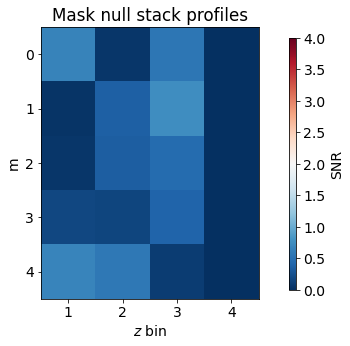

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# # scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
# snr_plot = ax.imshow(masknull_snr, cmap='RdBu_r', vmin=0, vmax=4)
# ax.set_ylabel("m")
# # axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# # replace x ticks with r values
# ax.set_xticks(np.arange(len(dbins)))
# ax.set_xticklabels(["1", "2", "3", "4"])


# # ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
# ax.set_xlabel(r"$z$ bin")
# plt.title("Mask null stack profiles")
# # add an axis for a colorbar
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
# # centered title
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/snr_test_masknull_100.pdf", bbox_inches="tight")
# plt.show()

In [11]:
# plot the ptes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax.imshow(masknull_pte, cmap=scmap, vmin=0, vmax=1)
ax.set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax.set_xticks(np.arange(len(dbins)))
ax.set_xticklabels(["1", "2", "3", "4"])


[Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')]

ValueError: data mapping points must have x in increasing order

<Figure size 360x360 with 1 Axes>

retrieving data from /mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_mask_redmapper_lambdagt20_combined_893_3193Mpc_nugt2_egtpt3_20pt0_orientXYUP_100pct_maglim_843_3243Mpc_cc_24reg_m0to5_profiles.pkl


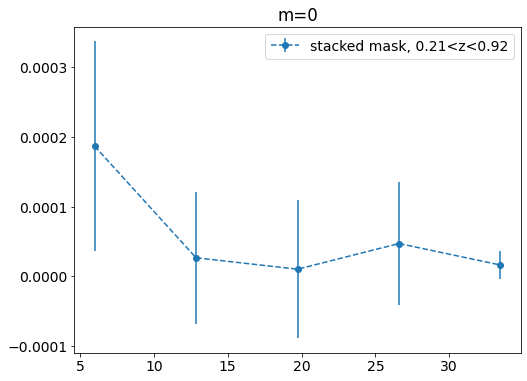

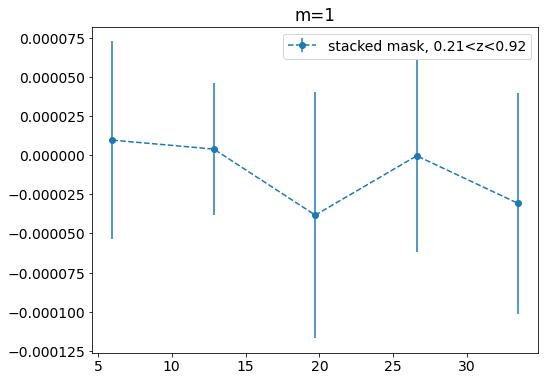

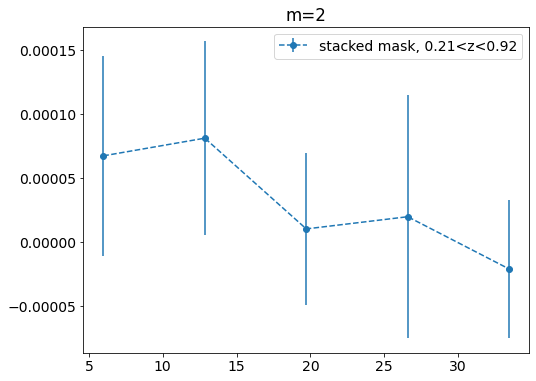

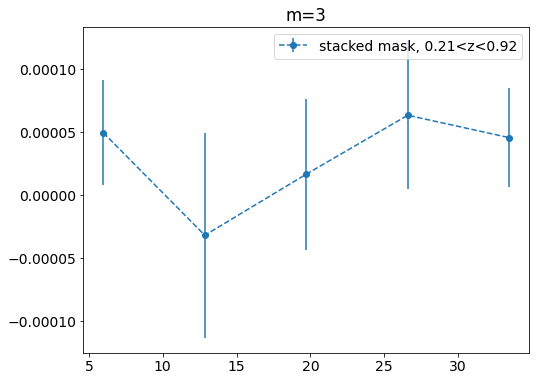

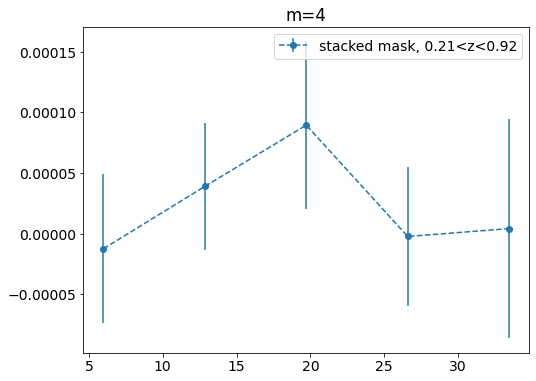

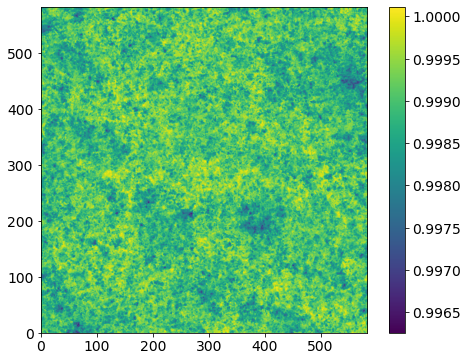

<Figure size 576x432 with 0 Axes>

In [8]:
cl_dbin = [893, 3193]
profs_dbin = []
errors_dbin = []
# masknull_snr_tot = np.zeros((5,1))
masknull_chi2_tot = np.zeros((5,1))
masknull_pte_tot = np.zeros((5,1))
mapstr = f'DES_mask'
mask, (zlow,zhi) = cpp.retrieve_stack_info(maskpath, mapstr, pt_selection_str, cl_dbin, remove_r30=True, pct=100)
mlen = mask.profile_splits.shape[0]

for m in range(mlen):
    null_vector = np.zeros(len(mask.avg_profiles_binned[m]))
    try:
        chi2 = st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])
    except:
        print("not pos def")
        chi2 = np.nan
# print("Chi-squared of mask stack w.r.t. zero", st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])/(len(mask.avg_profiles[m])-1))
    # pte, snr, vals = st.snr_from_pte(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m], chisq_data=None)
    # masknull_snr_tot[m,0] = snr
    pte = sp.stats.chi2.sf(chi2, dof)
    masknull_pte_tot[m,0] = pte
    masknull_chi2_tot[m,0] = chi2
    plt.errorbar(mask.r_binned, mask.avg_profiles_binned[m], yerr=mask.errors_binned[m], fmt='o', linestyle='--', label='stacked mask, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.title("m={:d}".format(m))
    plt.show()
    plt.clf()
    
    

plt.imshow(mask.avg_img, origin='lower')
plt.colorbar()
plt.show()
plt.clf()

# print(mask.Npks_splits)
# profs_dbin.append(mask.avg_profiles_binned[m])
# errors_dbin.append(mask.errors_binned[m])



In [9]:
# is pte total consistent with a unofrm disitribution
from scipy.stats import kstest
ks, pval = kstest(masknull_pte_tot[m], 'uniform')
if pval < 0.05:
    print("Reject null hypothesis that PTEs are uniformly distributed")

(array([1., 0., 1., 0., 0., 0., 0., 1., 0., 2.]),
 array([0.29237594, 0.35625188, 0.42012782, 0.48400376, 0.5478797 ,
        0.61175564, 0.67563158, 0.73950752, 0.80338346, 0.8672594 ,
        0.93113534]),
 <BarContainer object of 10 artists>)

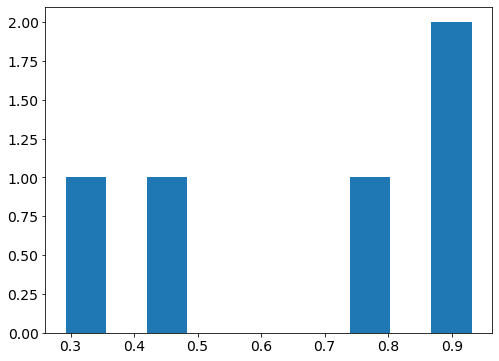

In [10]:
plt.hist(masknull_pte_tot)

NameError: name 'masknull_snr_tot' is not defined

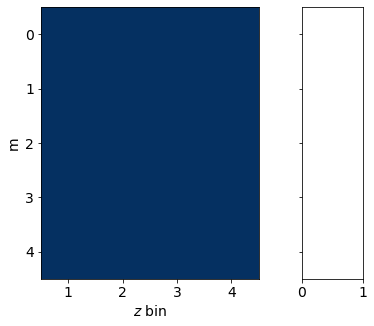

In [11]:
# set up figure with shared y and ratio 4 to 1
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
# scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax[0].imshow(masknull_snr, cmap='RdBu_r', vmin=0, vmax=4)
ax[0].set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
ax[1].imshow(masknull_snr_tot, cmap='RdBu_r', vmin=0, vmax=4)
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
plt.suptitle("Mask stack null tests")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/snr_test_masknull.pdf", bbox_inches="tight")
plt.show()


In [ ]:
masknull_pte

array([[0.97282809, 0.99880246, 0.97963894,        nan],
       [0.99943192, 0.98879786, 0.96642486,        nan],
       [0.99896993, 0.98940459, 0.98455509,        nan],
       [0.99573165, 0.99634529, 0.98765511, 0.99912043],
       [0.97185924, 0.97853555, 0.99779139,        nan]])

In [ ]:
masknull_pte_tot

array([[0.94206754],
       [0.99821337],
       [0.9921218 ],
       [0.96922942],
       [0.99627789]])

In [13]:
masknull_pte

array([[0.50486995, 0.95120895, 0.58008353,        nan],
       [0.97487334, 0.71360279, 0.44654359,        nan],
       [0.95724168, 0.724334  , 0.645912  ,        nan],
       [0.85939534, 0.87566549, 0.69416832, 0.96281207],
       [0.49536636, 0.56678062, 0.91765623,        nan]])

0.29237593853236227 0.9311353350917398
0.4465435852004661 0.9748733404594694


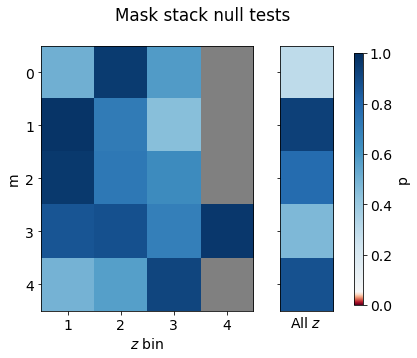

In [22]:
# pte version
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
masked_masknull_pte = np.ma.array(masknull_pte, mask=np.isnan(masknull_pte))
scmap.set_bad('grey',1.)
snr_plot = ax[0].imshow(masknull_pte, cmap=scmap, vmin=0, vmax=1)
ax[0].set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
ax[1].imshow(masknull_pte_tot, cmap=scmap, vmin=0, vmax=1)
print(np.amin(masknull_pte_tot), np.amax(masknull_pte_tot))
print(np.amin(masked_masknull_pte), np.amax(masked_masknull_pte))
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="p")
plt.suptitle("Mask stack null tests")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/snr_test_masknull.pdf", bbox_inches="tight")
plt.show()


In [ ]:
for n, m in enumerate(mask.img_splits):
    plt.imshow(m, origin='lower', vmax=1.1, vmin=0.9)
    plt.colorbar()
    plt.show()
    plt.clf()
    print(np.sum(m)/np.size(m))
    print(mask.Npks_splits[n])
